In [ ]:
!pip install matplotlib numpy pillow opencv-python --no-index
!pip install scikit-learn tensorboard pytorch-lightning comet-ml --no-index
!pip install --upgrade --force-reinstall torch torchvision --no-index

## Imports

In [3]:
import torch
import os
import random
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl
from Model.model import gazetrack_model
from Model.gazetrack_data import gazetrack_dataset

root = os.environ['SLURM_TMPDIR']

In [4]:
import colorsys
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

## Load model and weights

In [ ]:
model = gazetrack_model()
if(torch.cuda.is_available()):
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')
    
weights = torch.load("./Checkpoints/GoogleCheckpoint_1.ckpt", map_location=dev)['state_dict']
model.load_state_dict(weights)
model.to(dev)
model.eval()

## Run predictions on entire test set

In [11]:
file_root = root+"/gt_fin/test/images/"
test_dataset = gazetrack_dataset(file_root, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

preds, gt = [], []
for j in tqdm(test_dataloader):
    leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.cpu().detach().numpy()
    preds.extend(pred)  
    
    gt.extend(target.cpu().detach().numpy())
    
preds = np.array(preds)
pts = np.unique(gt, axis=0)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

  0%|          | 0/217 [00:00<?, ?it/s]

Num files for test = 55541


100%|██████████| 217/217 [00:21<00:00, 10.09it/s]

Mean Euclidean Distance:  2.0386193


In [12]:
all_files = glob(root+"/gt_fin/test/images/*.jpg")
all_files = [i[:-10] for i in all_files]
files = np.unique(all_files)
print('Found ', len(all_files), ' images from ', len(files), ' subjects.')

Found  55541  images from  121  subjects.


device:  iPhone 5S
id:  62
Num files:  472
Sample:


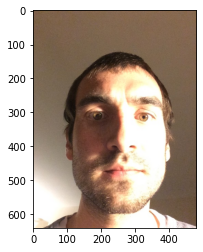

In [13]:
idx = np.random.randint(len(files))
meta = json.load(open(glob(files[idx].replace('images', 'meta')+"*.json")[0]))
print("device: ", meta['device'])
print("id: ", idx)
print("Num files: ", len(glob(files[idx]+"*.jpg")))
print("Sample:")
plt.imshow(plt.imread(glob(files[idx]+"*.jpg")[0]))

In [15]:
preds, gt = [], []
ctr = 1
f = files[idx]
# f = root+'/dataset/train/images/'
fs = glob(f+"*.jpg")
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.cpu().detach().numpy()
    preds.extend(pred)  
    
    gt.extend(target.cpu().detach().numpy())
    
preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

  0%|          | 0/2 [00:00<?, ?it/s]

Num files for test = 472


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Mean Euclidean Distance:  1.8917933


(-13.0, 0.2)

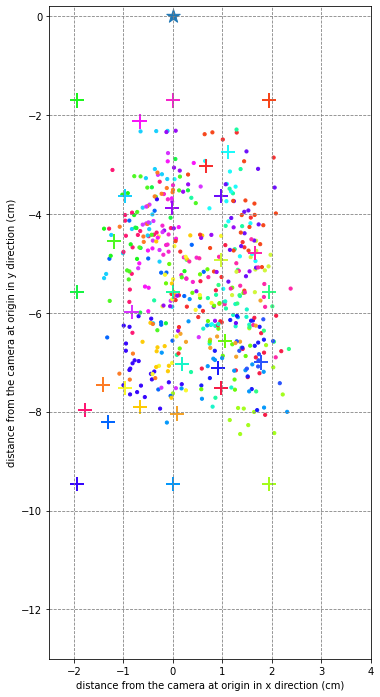

In [16]:
cols = np.zeros((len(gt),3))
for i in range(len(pts)):
    cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)

## Total Test

In [18]:
total_test = {}
for idx in tqdm(range(len(files))):
    preds, gt = [], []
    ctr = 1
    f = files[idx]
    test_dataset = gazetrack_dataset(f, phase='test', v=False)
    test_dataloader = DataLoader(test_dataset, batch_size=30, num_workers=10, pin_memory=False, shuffle=False,)

    for j in test_dataloader:
        leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)

        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.cpu().detach().numpy()
        preds.extend(pred)  

        gt.extend(target.cpu().detach().numpy())

    preds = np.array(preds)
    pts = np.unique(gt, axis=0)

    gt = np.array(gt)
    dist = euc(preds, gt)
    total_test[idx] = [dist, gt, preds, pts]

  0%|          | 0/121 [00:00<?, ?it/s]

Num files for test = 230


  1%|          | 1/121 [00:01<03:09,  1.58s/it]

Num files for test = 441


  2%|▏         | 2/121 [00:03<03:19,  1.68s/it]

Num files for test = 244


  2%|▏         | 3/121 [00:04<03:13,  1.64s/it]

Num files for test = 168


  3%|▎         | 4/121 [00:06<02:59,  1.53s/it]

Num files for test = 464


  4%|▍         | 5/121 [00:07<03:00,  1.56s/it]

Num files for test = 224


  5%|▍         | 6/121 [00:09<02:58,  1.55s/it]

Num files for test = 427


  6%|▌         | 7/121 [00:11<03:04,  1.61s/it]

Num files for test = 69


  7%|▋         | 8/121 [00:12<02:52,  1.53s/it]

Num files for test = 402


  7%|▋         | 9/121 [00:14<03:02,  1.63s/it]

Num files for test = 398


  8%|▊         | 10/121 [00:16<03:04,  1.66s/it]

Num files for test = 399


  9%|▉         | 11/121 [00:17<03:04,  1.67s/it]

Num files for test = 851


 10%|▉         | 12/121 [00:19<03:16,  1.81s/it]

Num files for test = 57


 11%|█         | 13/121 [00:21<03:00,  1.67s/it]

Num files for test = 121


 12%|█▏        | 14/121 [00:22<02:54,  1.63s/it]

Num files for test = 598


 12%|█▏        | 15/121 [00:24<03:03,  1.74s/it]

Num files for test = 679


 13%|█▎        | 16/121 [00:26<03:10,  1.82s/it]

Num files for test = 384


 14%|█▍        | 17/121 [00:28<03:06,  1.79s/it]

Num files for test = 603


 15%|█▍        | 18/121 [00:30<03:07,  1.82s/it]

Num files for test = 686


 16%|█▌        | 19/121 [00:32<03:06,  1.83s/it]

Num files for test = 448


 17%|█▋        | 20/121 [00:34<03:02,  1.80s/it]

Num files for test = 389


 17%|█▋        | 21/121 [00:35<02:56,  1.77s/it]

Num files for test = 66


 18%|█▊        | 22/121 [00:36<02:37,  1.59s/it]

Num files for test = 190


 19%|█▉        | 23/121 [00:38<02:28,  1.51s/it]

Num files for test = 225


 20%|█▉        | 24/121 [00:39<02:23,  1.48s/it]

Num files for test = 264


 21%|██        | 25/121 [00:41<02:27,  1.54s/it]

Num files for test = 299


 21%|██▏       | 26/121 [00:42<02:26,  1.55s/it]

Num files for test = 408


 22%|██▏       | 27/121 [00:44<02:31,  1.61s/it]

Num files for test = 714


 23%|██▎       | 28/121 [00:46<02:41,  1.73s/it]

Num files for test = 375


 24%|██▍       | 29/121 [00:48<02:36,  1.70s/it]

Num files for test = 763


 25%|██▍       | 30/121 [00:50<02:49,  1.86s/it]

Num files for test = 69


 26%|██▌       | 31/121 [00:52<02:41,  1.79s/it]

Num files for test = 81


 26%|██▋       | 32/121 [00:53<02:29,  1.68s/it]

Num files for test = 253


 27%|██▋       | 33/121 [00:55<02:25,  1.65s/it]

Num files for test = 328


 28%|██▊       | 34/121 [00:56<02:19,  1.61s/it]

Num files for test = 617


 29%|██▉       | 35/121 [00:58<02:25,  1.69s/it]

Num files for test = 394


 30%|██▉       | 36/121 [01:00<02:27,  1.73s/it]

Num files for test = 409


 31%|███       | 37/121 [01:01<02:22,  1.69s/it]

Num files for test = 322


 31%|███▏      | 38/121 [01:03<02:16,  1.65s/it]

Num files for test = 200


 32%|███▏      | 39/121 [01:05<02:19,  1.70s/it]

Num files for test = 680


 33%|███▎      | 40/121 [01:07<02:22,  1.76s/it]

Num files for test = 784


 34%|███▍      | 41/121 [01:09<02:31,  1.90s/it]

Num files for test = 628


 35%|███▍      | 42/121 [01:11<02:30,  1.91s/it]

Num files for test = 443


 36%|███▌      | 43/121 [01:13<02:24,  1.85s/it]

Num files for test = 303


 36%|███▋      | 44/121 [01:14<02:18,  1.80s/it]

Num files for test = 308


 37%|███▋      | 45/121 [01:16<02:08,  1.69s/it]

Num files for test = 479


 38%|███▊      | 46/121 [01:17<02:07,  1.70s/it]

Num files for test = 615


 39%|███▉      | 47/121 [01:19<02:10,  1.76s/it]

Num files for test = 349


 40%|███▉      | 48/121 [01:21<02:07,  1.74s/it]

Num files for test = 442


 40%|████      | 49/121 [01:23<02:02,  1.70s/it]

Num files for test = 221


 41%|████▏     | 50/121 [01:24<01:55,  1.63s/it]

Num files for test = 264


 42%|████▏     | 51/121 [01:26<01:54,  1.63s/it]

Num files for test = 539


 43%|████▎     | 52/121 [01:27<01:54,  1.67s/it]

Num files for test = 678


 44%|████▍     | 53/121 [01:29<02:00,  1.77s/it]

Num files for test = 522


 45%|████▍     | 54/121 [01:31<01:59,  1.79s/it]

Num files for test = 321


 45%|████▌     | 55/121 [01:33<01:52,  1.70s/it]

Num files for test = 247


 46%|████▋     | 56/121 [01:34<01:44,  1.60s/it]

Num files for test = 534


 47%|████▋     | 57/121 [01:36<01:45,  1.65s/it]

Num files for test = 134


 48%|████▊     | 58/121 [01:38<01:43,  1.64s/it]

Num files for test = 682


 49%|████▉     | 59/121 [01:40<01:48,  1.74s/it]

Num files for test = 396


 50%|████▉     | 60/121 [01:41<01:44,  1.71s/it]

Num files for test = 611


 50%|█████     | 61/121 [01:43<01:44,  1.75s/it]

Num files for test = 860


 51%|█████     | 62/121 [01:45<01:48,  1.83s/it]

Num files for test = 472


 52%|█████▏    | 63/121 [01:47<01:42,  1.76s/it]

Num files for test = 387


 53%|█████▎    | 64/121 [01:48<01:38,  1.72s/it]

Num files for test = 658


 54%|█████▎    | 65/121 [01:50<01:40,  1.80s/it]

Num files for test = 229


 55%|█████▍    | 66/121 [01:52<01:34,  1.72s/it]

Num files for test = 710


 55%|█████▌    | 67/121 [01:54<01:38,  1.83s/it]

Num files for test = 476


 56%|█████▌    | 68/121 [01:56<01:33,  1.77s/it]

Num files for test = 505


 57%|█████▋    | 69/121 [01:57<01:31,  1.76s/it]

Num files for test = 748


 58%|█████▊    | 70/121 [01:59<01:32,  1.82s/it]

Num files for test = 535


 59%|█████▊    | 71/121 [02:01<01:30,  1.81s/it]

Num files for test = 786


 60%|█████▉    | 72/121 [02:03<01:33,  1.91s/it]

Num files for test = 788


 60%|██████    | 73/121 [02:05<01:34,  1.98s/it]

Num files for test = 119


 61%|██████    | 74/121 [02:07<01:24,  1.79s/it]

Num files for test = 70


 62%|██████▏   | 75/121 [02:08<01:16,  1.66s/it]

Num files for test = 433


 63%|██████▎   | 76/121 [02:10<01:14,  1.66s/it]

Num files for test = 551


 64%|██████▎   | 77/121 [02:12<01:17,  1.75s/it]

Num files for test = 801


 64%|██████▍   | 78/121 [02:14<01:18,  1.83s/it]

Num files for test = 319


 65%|██████▌   | 79/121 [02:15<01:09,  1.66s/it]

Num files for test = 77


 66%|██████▌   | 80/121 [02:16<01:01,  1.49s/it]

Num files for test = 296


 67%|██████▋   | 81/121 [02:17<00:57,  1.43s/it]

Num files for test = 238


 68%|██████▊   | 82/121 [02:19<00:53,  1.37s/it]

Num files for test = 864


 69%|██████▊   | 83/121 [02:20<00:56,  1.50s/it]

Num files for test = 321


 69%|██████▉   | 84/121 [02:22<00:53,  1.44s/it]

Num files for test = 670


 70%|███████   | 85/121 [02:23<00:54,  1.52s/it]

Num files for test = 695


 71%|███████   | 86/121 [02:25<00:52,  1.51s/it]

Num files for test = 781


 72%|███████▏  | 87/121 [02:26<00:50,  1.50s/it]

Num files for test = 411


 73%|███████▎  | 88/121 [02:28<00:47,  1.44s/it]

Num files for test = 605


 74%|███████▎  | 89/121 [02:29<00:45,  1.42s/it]

Num files for test = 712


 74%|███████▍  | 90/121 [02:30<00:44,  1.45s/it]

Num files for test = 515


 75%|███████▌  | 91/121 [02:32<00:43,  1.45s/it]

Num files for test = 796


 76%|███████▌  | 92/121 [02:33<00:41,  1.45s/it]

Num files for test = 537


 77%|███████▋  | 93/121 [02:35<00:40,  1.44s/it]

Num files for test = 414


 78%|███████▊  | 94/121 [02:36<00:37,  1.40s/it]

Num files for test = 574


 79%|███████▊  | 95/121 [02:37<00:35,  1.38s/it]

Num files for test = 708


 79%|███████▉  | 96/121 [02:39<00:35,  1.40s/it]

Num files for test = 665


 80%|████████  | 97/121 [02:41<00:35,  1.48s/it]

Num files for test = 215


 81%|████████  | 98/121 [02:42<00:32,  1.39s/it]

Num files for test = 701


 82%|████████▏ | 99/121 [02:43<00:31,  1.43s/it]

Num files for test = 721


 83%|████████▎ | 100/121 [02:45<00:31,  1.49s/it]

Num files for test = 588


 83%|████████▎ | 101/121 [02:46<00:29,  1.49s/it]

Num files for test = 643


 84%|████████▍ | 102/121 [02:48<00:28,  1.51s/it]

Num files for test = 783


 85%|████████▌ | 103/121 [02:49<00:26,  1.48s/it]

Num files for test = 431


 86%|████████▌ | 104/121 [02:51<00:24,  1.41s/it]

Num files for test = 874


 87%|████████▋ | 105/121 [02:52<00:22,  1.42s/it]

Num files for test = 566


 88%|████████▊ | 106/121 [02:53<00:20,  1.38s/it]

Num files for test = 175


 88%|████████▊ | 107/121 [02:54<00:17,  1.28s/it]

Num files for test = 700


 89%|████████▉ | 108/121 [02:56<00:17,  1.33s/it]

Num files for test = 376


 90%|█████████ | 109/121 [02:57<00:15,  1.32s/it]

Num files for test = 179


 91%|█████████ | 110/121 [02:58<00:14,  1.31s/it]

Num files for test = 328


 92%|█████████▏| 111/121 [03:00<00:12,  1.27s/it]

Num files for test = 270


 93%|█████████▎| 112/121 [03:01<00:11,  1.24s/it]

Num files for test = 644


 93%|█████████▎| 113/121 [03:02<00:10,  1.33s/it]

Num files for test = 703


 94%|█████████▍| 114/121 [03:04<00:09,  1.39s/it]

Num files for test = 371


 95%|█████████▌| 115/121 [03:05<00:08,  1.35s/it]

Num files for test = 706


 96%|█████████▌| 116/121 [03:07<00:06,  1.38s/it]

Num files for test = 183


 97%|█████████▋| 117/121 [03:08<00:05,  1.30s/it]

Num files for test = 278


 98%|█████████▊| 118/121 [03:09<00:03,  1.29s/it]

Num files for test = 542


 98%|█████████▊| 119/121 [03:10<00:02,  1.32s/it]

Num files for test = 47


 99%|█████████▉| 120/121 [03:11<00:01,  1.26s/it]

Num files for test = 752


100%|██████████| 121/121 [03:13<00:00,  1.60s/it]


2.0357125

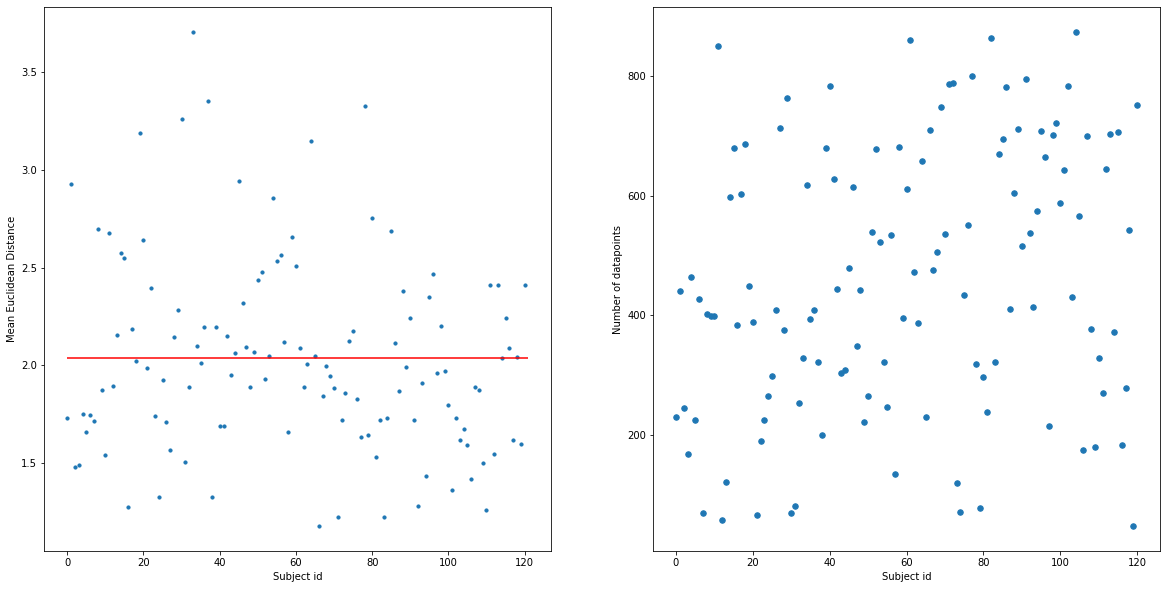

In [19]:
mean_errs = []
for i in total_test:
    mean_errs.append(np.mean(total_test[i][0]))
    
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter([i for i in range(len(mean_errs))], mean_errs, s=10)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='r')
plt.xlabel('Subject id')
plt.ylabel('Mean Euclidean Distance')
plt.subplot(1,2,2)
plt.scatter([i for i in range(len(mean_errs))], [len(total_test[i][0]) for i in total_test], s=30)
plt.xlabel('Subject id')
plt.ylabel('Number of datapoints')
np.mean(mean_errs)

In [ ]:
np.std(mean_errs)/np.sqrt(len(mean_errs))

In [ ]:
dists = [total_test[i][0] for i in total_test]
plt.figure(figsize=(24,12))
plt.boxplot(dists)
plt.xlabel('Subject id')
plt.ylabel('Euc Distance')
a=1

In [ ]:
mean_errs = []
for i in total_test:
    mean_errs.extend(total_test[i][0])
plt.figure(figsize=(24, 12))
plt.scatter([i for i in range(len(mean_errs))], mean_errs, s=10)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='r')
plt.xlabel('Test point id')
plt.ylabel('Mean Euclidean Distance')
np.mean(mean_errs)

In [ ]:
pts = np.unique(gt, axis=0)
cols = np.zeros((len(gt),3))
for i in range(len(pts)):
    cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)